# Multi-Class Model for Fetal Health Classification Using TensorFlow Decision Forests
### David Lowe
### February 21, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Fetal Health Classification dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset contains 2,126 records of features extracted from Cardiotocography exams. Cardiotocograms are a simple and cost accessible option to assess fetal health. The equipment works by sending ultrasound pulses and reading its response, thus highlighting fetal heart rate, fetal movements, uterine contractions, and more. Three expert obstetricians classified the outcomes into three classes: Normal, Suspect, and Pathological.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved an accuracy benchmark of 99.50% on the training dataset. When we applied the finalized model to the test dataset, the model achieved an accuracy score of 92.79%.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Fetal Health Classification Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.kaggle.com/andrewmvd/fetal-health-classification

One source of potential performance benchmarks: https://www.kaggle.com/andrewmvd/fetal-health-classification/code

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.SparseCategoricalCrossentropy()]

# Define the directory locations and file names
TRAIN_DATASET = 'fetal_health.csv'
# TEST_DATASET = ''

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.8.0
Found TensorFlow Decision Forests v0.2.4


2022-02-19 01:44:23.729861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 01:44:23.741259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 01:44:23.742003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 01:44:23.743636: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-andrewmvd-fetal-health-classification/fetal_health.csv

In [9]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [11]:
print(df_dataset_import.describe())

       baseline value  accelerations  fetal_movement  uterine_contractions  \
count     2126.000000    2126.000000     2126.000000           2126.000000   
mean       133.303857       0.003178        0.009481              0.004366   
std          9.840844       0.003866        0.046666              0.002946   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.004000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2126.000000           2126.000000               2126.000000   
mean              0.001889              0.000003                  0.000159   
std               0.002960              0.000057               

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('fetal_health').size())

fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'fetal_health': 'target'})

# Convert columns from one data type to another
df_dataset_import.target = df_dataset_import.target.astype('int')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [16]:
print(df_dataset_import.describe())

       baseline value  accelerations  fetal_movement  uterine_contractions  \
count     2126.000000    2126.000000     2126.000000           2126.000000   
mean       133.303857       0.003178        0.009481              0.004366   
std          9.840844       0.003866        0.046666              0.002946   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.004000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2126.000000           2126.000000               2126.000000   
mean              0.001889              0.000003                  0.000159   
std               0.002960              0.000057               

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
1    1655
2     295
3     176
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Split the data further into training and test datasets
df_dataset_train, df_dataset_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                     stratify=df_dataset_import['target'])
print("df_dataset_train.shape: {} df_dataset_test.shape: {}".format(df_dataset_train.shape, df_dataset_test.shape))

df_dataset_train.shape: (1807, 22) df_dataset_test.shape: (319, 22)


In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_train['target']
df_features_train = df_dataset_train.drop(['target'], axis=1)

print("df_dataset_train.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_train.shape, df_features_train.shape, df_target_train.shape))

df_dataset_train.shape: (1807, 22) df_features_train.shape: (1807, 21) df_target_train.shape: (1807,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

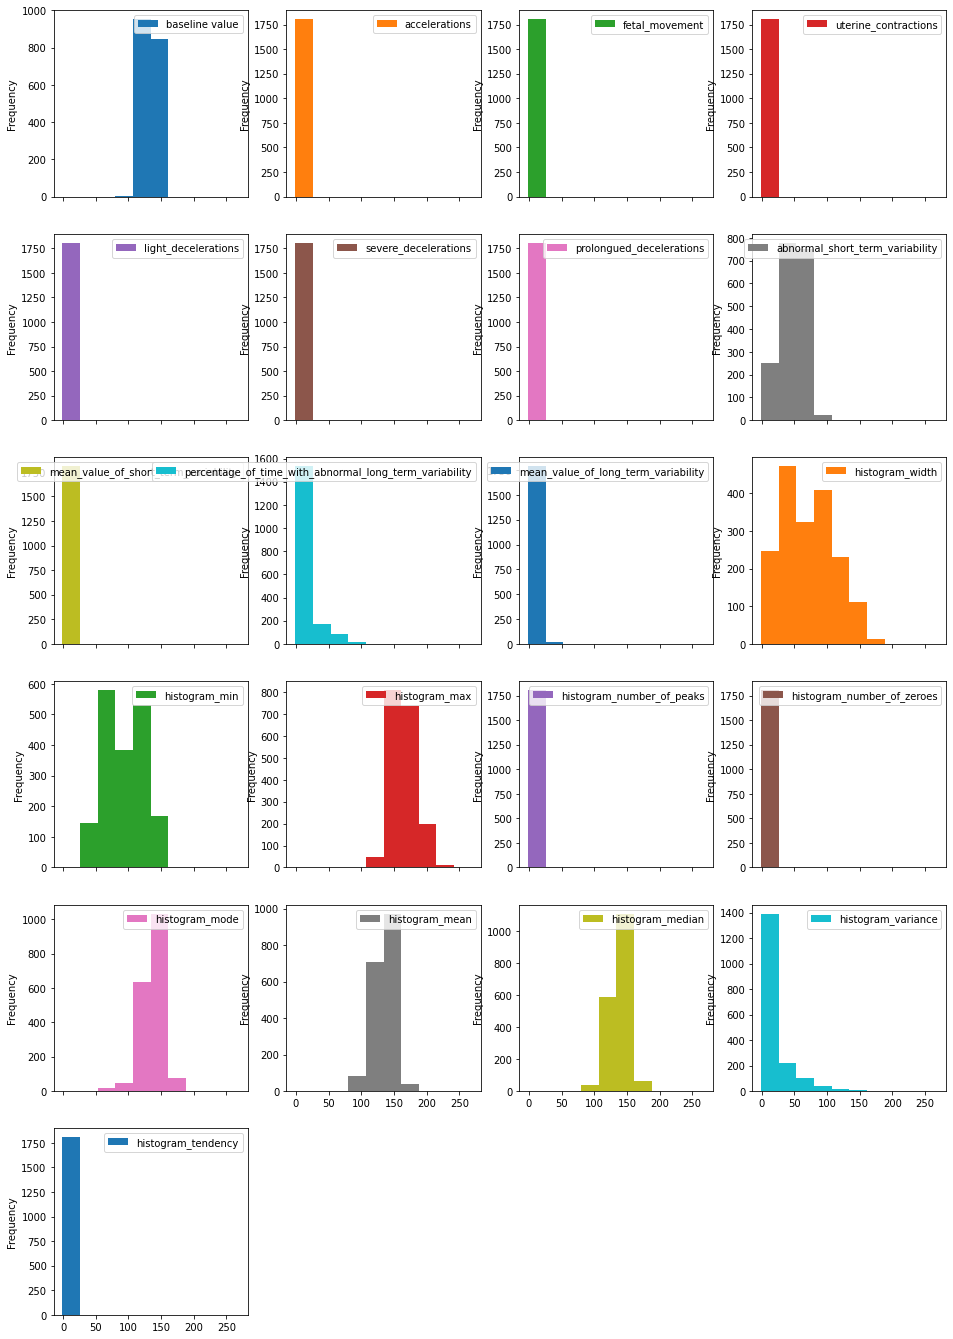

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

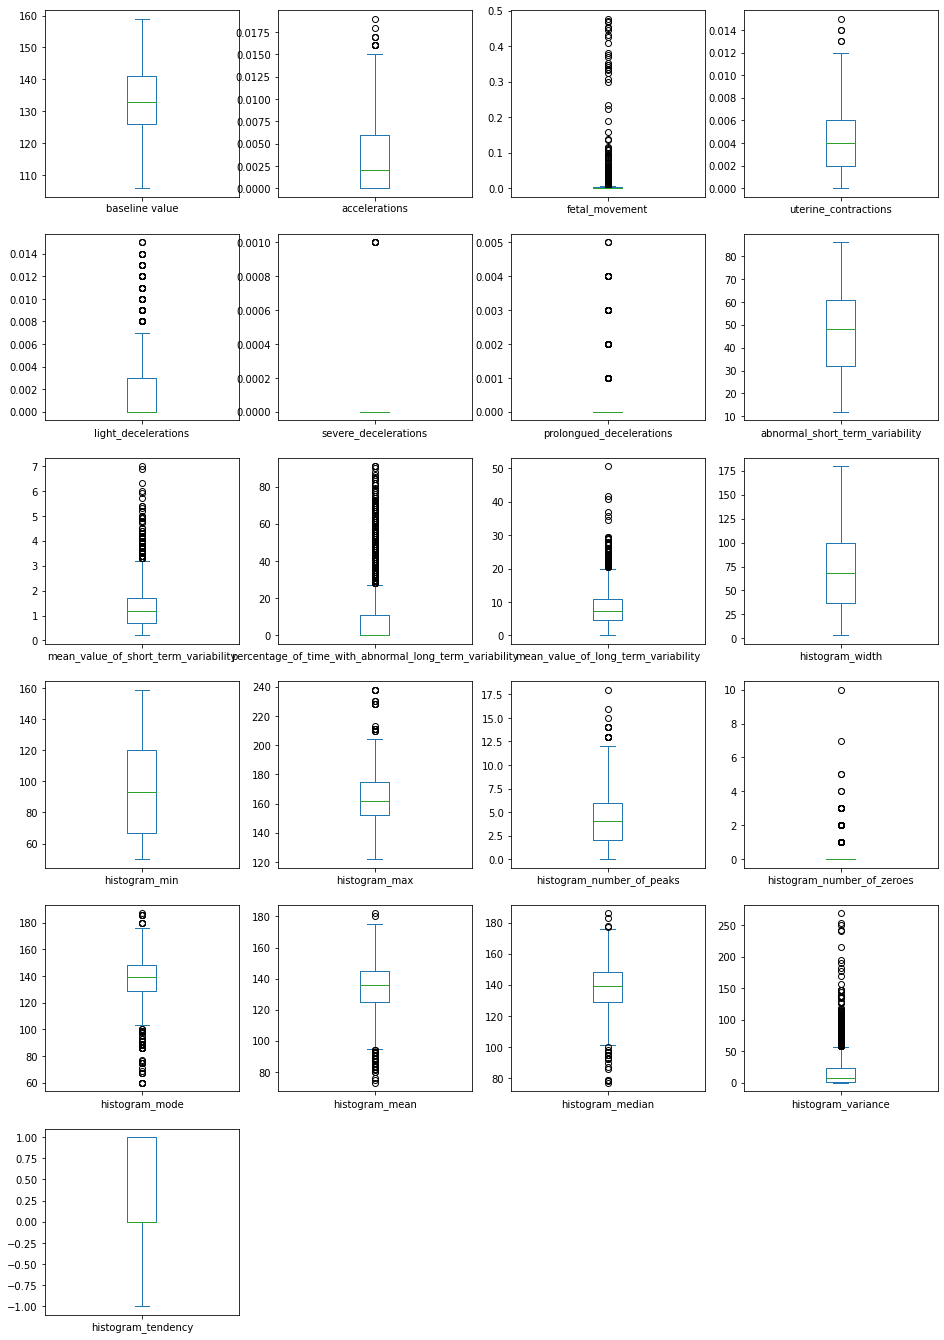

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

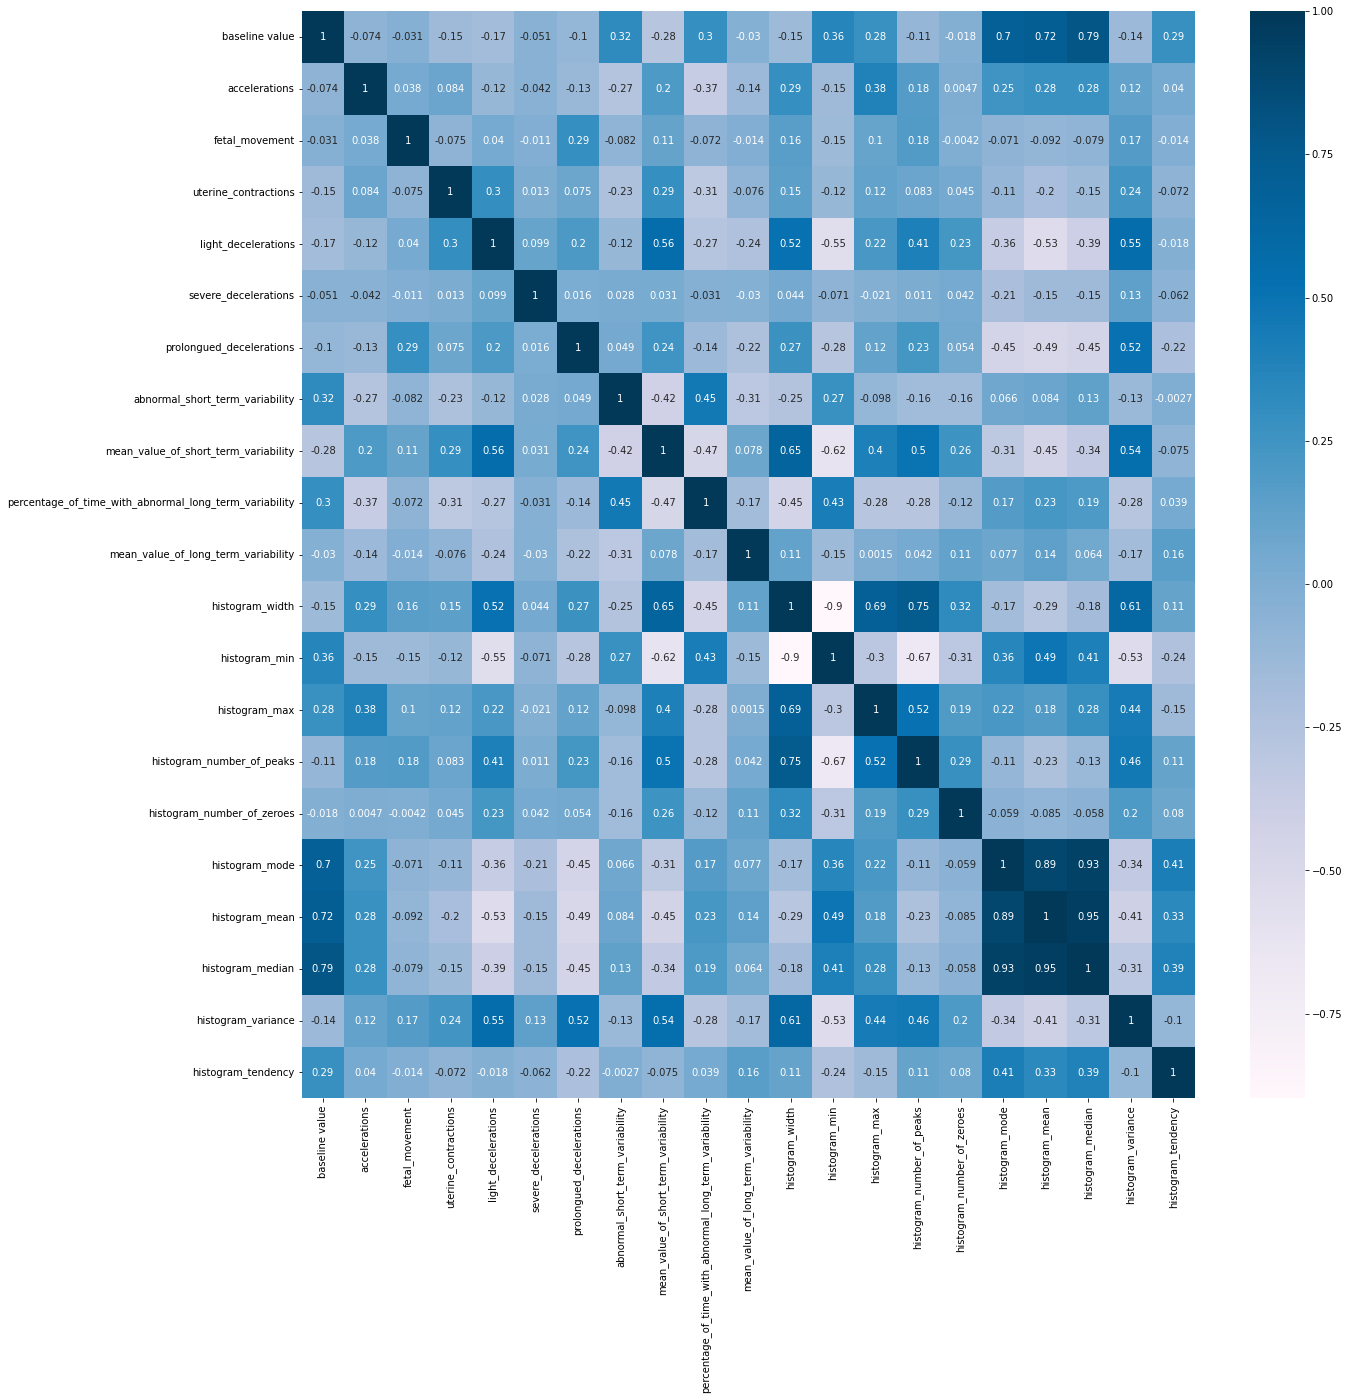

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [29]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [30]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp_0678gf4 as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 3s
Dataset read in 0:00:03.136934
Training model
Model trained in 0:00:00.210428
Compiling model
2/2 [==============================] - 3s 342ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model training time: 0:00:04.779503 



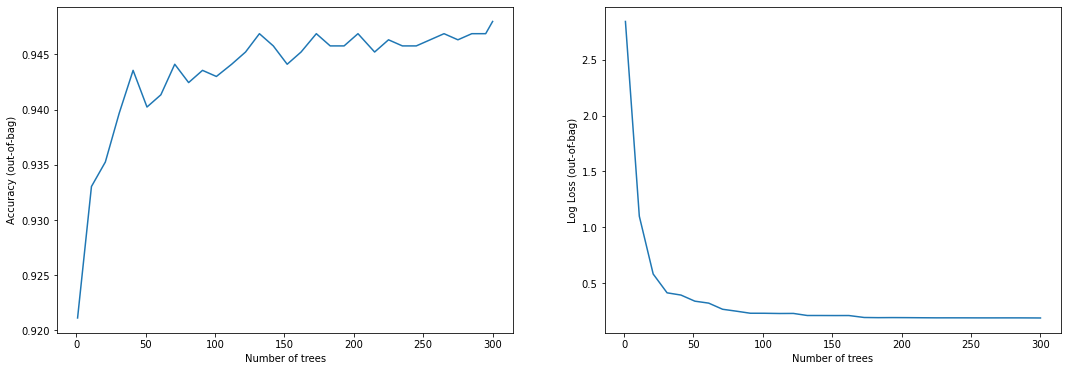

In [31]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [32]:
RF_eval = RF_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 0.9812 - sparse_categorical_crossentropy: 0.0757

loss: 0.0000
accuracy: 0.9812
sparse_categorical_crossentropy: 0.0757


### 3.c) Train and Evaluate the Decision Trees Model

In [33]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpjkphqvkl as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.223725
Training model
Model trained in 0:00:00.006799
Compiling model
2/2 [==============================] - 0s 23ms/step
Model training time: 0:00:00.434483 



[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


In [34]:
CART_eval = CART_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.9297 - sparse_categorical_crossentropy: 0.1646

loss: 0.0000
accuracy: 0.9297
sparse_categorical_crossentropy: 0.1646


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [35]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp596kuk94 as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.213449
Training model
Model trained in 0:00:01.863560
Compiling model
2/2 [==============================] - 2s 2s/step


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


Model training time: 0:00:02.335420 



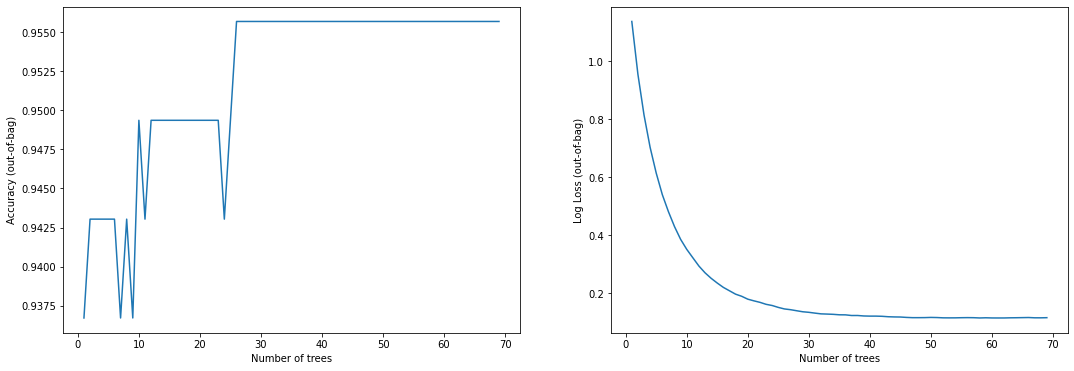

In [36]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [37]:
GBT_eval = GBT_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 0.9950 - sparse_categorical_crossentropy: 0.1182

loss: 0.0000
accuracy: 0.9950
sparse_categorical_crossentropy: 0.1182


In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Not applicable for this iteration of modeling

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [43]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpg1rso78s as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.225805
Training model
Model trained in 0:00:01.829926
Compiling model
2/2 [==============================] - 2s 2s/step
Model training time: 0:00:02.289317 



[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


In [44]:
Final_model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (21):
	abnormal_short_term_variability
	accelerations
	baseline_value
	fetal_movement
	histogram_max
	histogram_mean
	histogram_median
	histogram_min
	histogram_mode
	histogram_number_of_peaks
	histogram_number_of_zeroes
	histogram_tendency
	histogram_variance
	histogram_width
	light_decelerations
	mean_value_of_long_term_variability
	mean_value_of_short_term_variability
	percentage_of_time_with_abnormal_long_term_variability
	prolongued_decelerations
	severe_decelerations
	uterine_contractions

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                   "severe_decelerations"  4.

### 5.b) Load Test Dataset and Make Predictions

In [45]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_test, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [46]:
Final_eval = Final_model.evaluate(tfds_test, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 179ms/step - loss: 0.0000e+00 - accuracy: 0.9279 - sparse_categorical_crossentropy: 0.1231

loss: 0.0000
accuracy: 0.9279
sparse_categorical_crossentropy: 0.1231


In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:00:18.514386
